In [1]:
from snowflake.snowpark import (
    Session,
    functions as F, 
    types as T
)
import os
import json
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest


In [2]:
connection_params = json.loads(os.environ["AIRFLOW_CONN_SNOWFLAKE_PROD"])
connection_params['user'] = connection_params.pop('login')
connection_params['account'] = connection_params['extra'].pop('account')
connection_params['database'] = connection_params['extra'].pop('database')
connection_params['schema'] = connection_params['schema']
connection_params['region'] = connection_params['extra'].pop('region')
connection_params['application'] = connection_params['extra'].pop('application')
snowpark_session = Session.builder.configs(connection_params).create()

In [3]:
account_start_cutoff_date = datetime.date(2022, 12, 17)

In [4]:
currency_usage = snowpark_session.table('SNOWFLAKE.ORGANIZATION_USAGE.USAGE_IN_CURRENCY_DAILY')

In [5]:
usage = currency_usage.filter((F.col('USAGE_DATE') >= account_start_cutoff_date) &
                              (F.col('USAGE_DATE') < datetime.date.today()))

usage_df = usage.select('USAGE_DATE', 'USAGE_TYPE', 'USAGE')\
                         .pivot(pivot_col='USAGE_TYPE', values=["compute", "storage"])\
                         .sum('USAGE')\
                         .sort('USAGE_DATE')\
                         .to_pandas()

usage_df.columns = ["date", "compute", "storage"]
usage_df.date = pd.to_datetime(usage_df.date)
usage_df.set_index('date', inplace=True)
usage_df.fillna(value=0, inplace=True)
usage_df = usage_df.apply(pd.to_numeric, downcast='float')
usage_df

,compute,storage
date,,
2022-12-17,55.317223,0.057134
2022-12-18,49.639999,0.056753
2022-12-19,82.614723,0.058063
2022-12-20,89.935837,0.061108
2022-12-21,81.370277,0.064228
...,...,...
2023-11-30,120.711945,0.193031
2023-12-01,135.488052,0.189543
2023-12-02,86.926941,0.191458


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


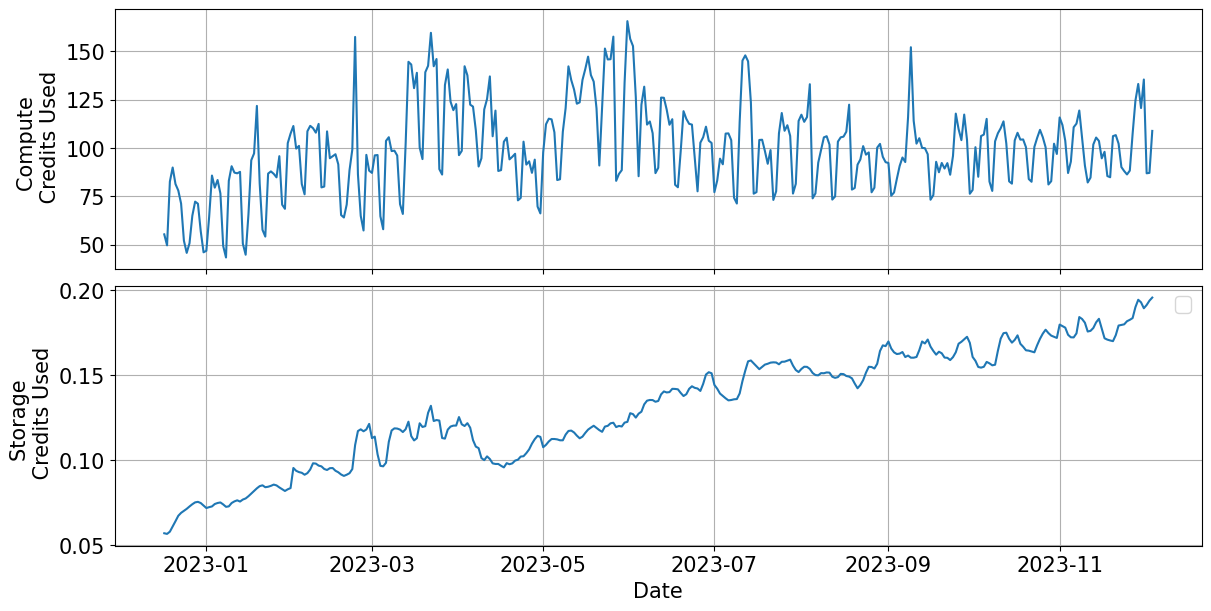

In [6]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

fig, axs = plt.subplots(2, 1, sharex='all', layout='constrained')
axs[0].plot(usage_df['compute'])
axs[0].set_ylabel('Compute \n Credits Used')
axs[0].grid(True)

axs[1].plot(usage_df['storage'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Storage \n Credits Used')
axs[1].grid(True)
plt.legend()
plt.show()

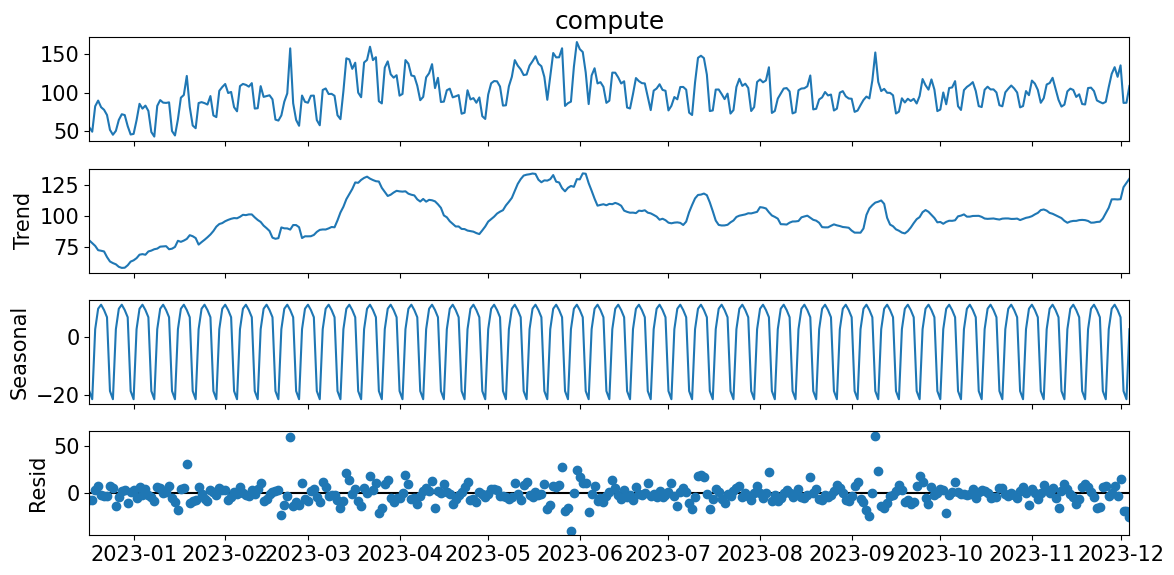

In [7]:
compute_stl = seasonal_decompose(x=usage_df.compute, model='additive', extrapolate_trend='freq')
compute_stationary = compute_stl.resid.values.reshape(-1,1)
fig = compute_stl.plot()


In [8]:
compute_model =  IsolationForest()
compute_model.fit(compute_stationary)

usage_df['compute_scores'] = compute_model.decision_function(compute_stationary) 
compute_threshold = usage_df['compute_scores'].mean() - (3 * usage_df['compute_scores'].std())

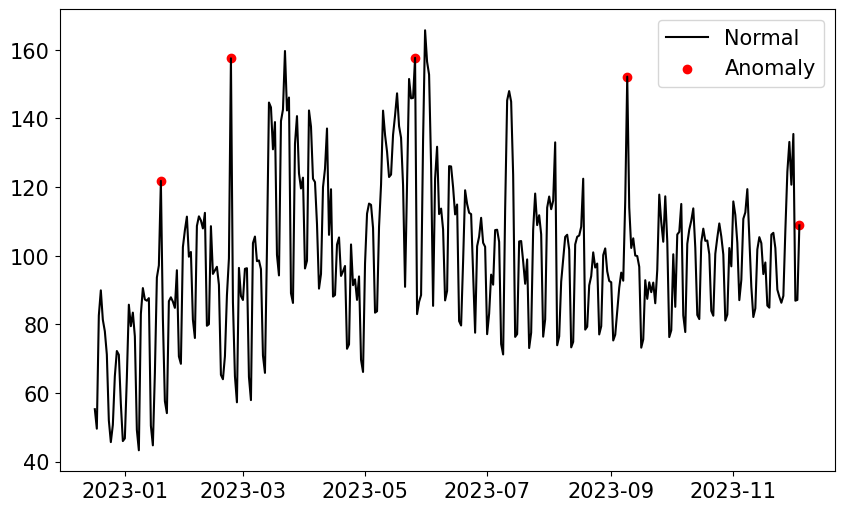

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

anomalies = usage_df.loc[(usage_df.compute_scores <= compute_threshold) & 
                         (usage_df.compute > usage_df.compute.mean()), ['compute']]
anomalies

ax.plot(usage_df.index, usage_df.compute, color='black', label = 'Normal')
ax.scatter(anomalies.index, anomalies.compute, color='red', label = 'Anomaly')
plt.legend()
plt.show()


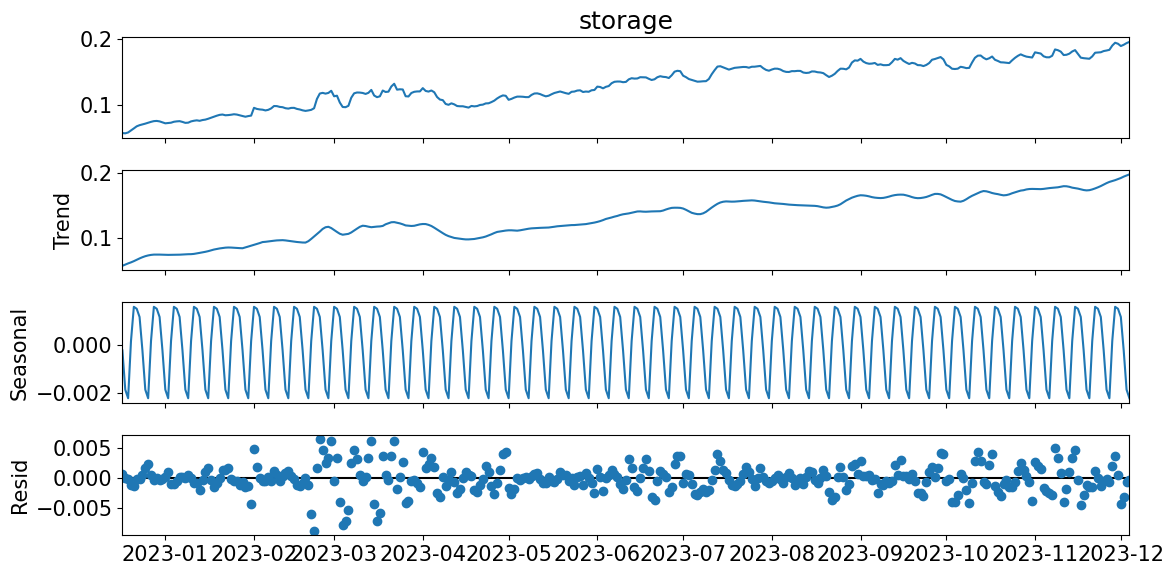

In [12]:
storage_stl = seasonal_decompose(usage_df.storage, model='additive', extrapolate_trend='freq')
storage_stationary = storage_stl.resid.values.reshape(-1,1)
fig = storage_stl.plot()

In [13]:
storage_model =  IsolationForest()
storage_model.fit(storage_stationary)

usage_df['storage_scores'] = storage_model.decision_function(storage_stationary) 
storage_threshold = usage_df['storage_scores'].mean() - (3 * usage_df['storage_scores'].std())

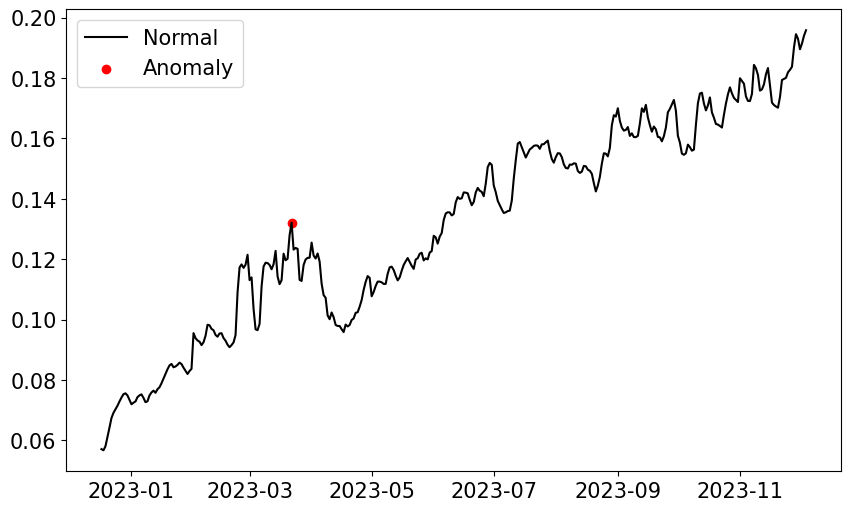

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

anomalies = usage_df.loc[(usage_df.storage_scores <= storage_threshold) & 
                         (usage_df.storage > usage_df.storage.mean()), ['storage']]
anomalies

ax.plot(usage_df.index, usage_df.storage, color='black', label = 'Normal')
ax.scatter(anomalies.index, anomalies.storage, color='red', label = 'Anomaly')
plt.legend()
plt.show()


## Combine all cost categories and predict on total usage in currency

In [15]:
usage = currency_usage.filter((F.col('USAGE_DATE') < datetime.date.today()) &
                              (F.col('USAGE_DATE') >= account_start_cutoff_date))

usage_df = usage.select('USAGE_DATE', 'USAGE_IN_CURRENCY')\
                         .group_by('USAGE_DATE')\
                         .sum('USAGE_IN_CURRENCY')\
                         .sort('USAGE_DATE')\
                         .to_pandas()

usage_df.columns = ["date", "usage"]
usage_df.date = pd.to_datetime(usage_df.date)
usage_df.set_index('date', inplace=True)
usage_df.fillna(value=0, inplace=True)
usage_df

,usage
date,
2022-12-17,116.204047
2022-12-18,105.398556
2022-12-19,172.172874
2022-12-20,192.999498
2022-12-21,172.023839
...,...
2023-11-30,231.223740
2023-12-01,256.369439
2023-12-02,171.486093


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


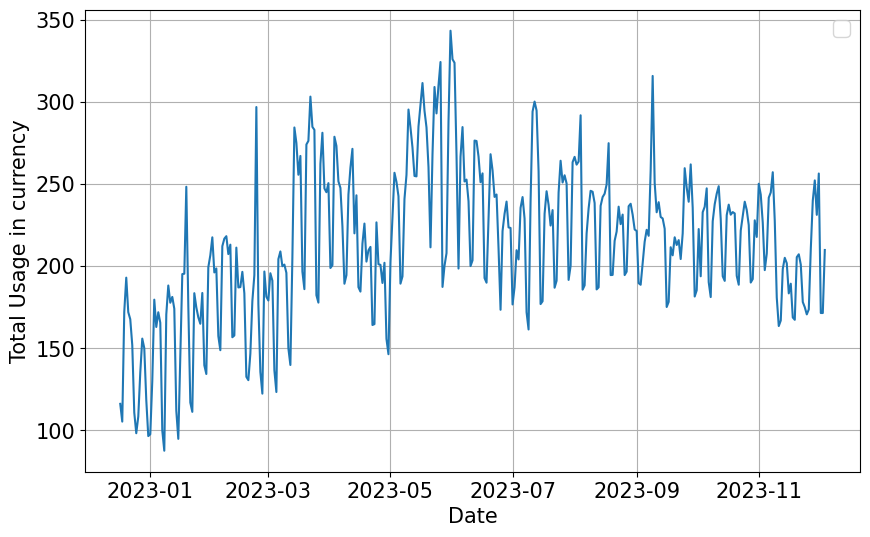

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(usage_df.usage)
ax.set_xlabel('Date')
ax.set_ylabel('Total Usage in currency')
ax.grid(True)
plt.legend()
plt.show()

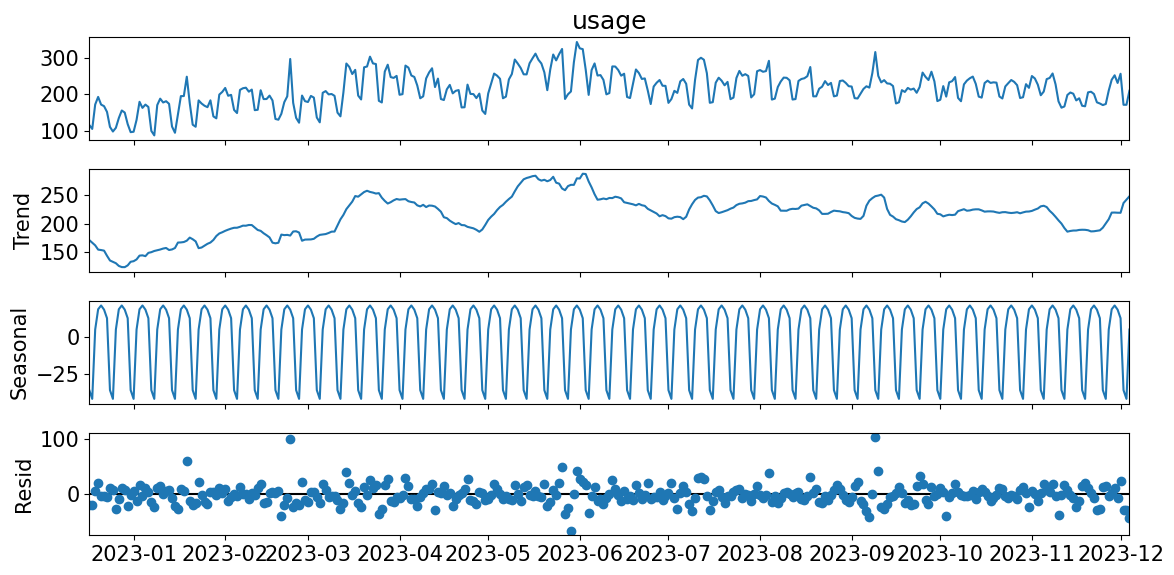

In [18]:
stl = seasonal_decompose(usage_df.usage, model='additive', extrapolate_trend='freq')
usage_stationary = stl.resid.values.reshape(-1,1)
fig = stl.plot()

In [19]:
usage_model =  IsolationForest()
usage_model.fit(usage_stationary)

usage_df['usage_scores'] = usage_model.decision_function(usage_stationary) 
usage_threshold = usage_df.usage_scores.mean() - (3 * usage_df.usage_scores.std())

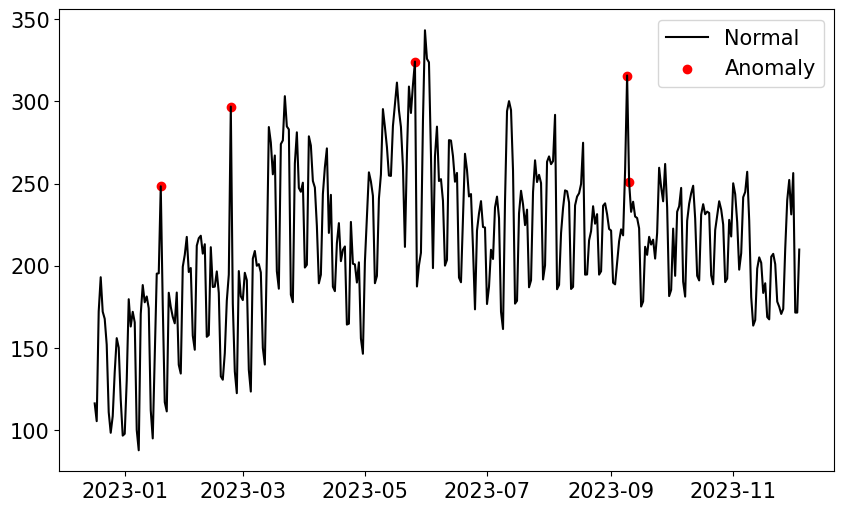

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

anomalies = usage_df.loc[(usage_df.usage_scores <= usage_threshold) & 
                         (usage_df.usage > usage_df.usage.mean()), ['usage']]
anomalies

ax.plot(usage_df.index, usage_df.usage, color='black', label = 'Normal')
ax.scatter(anomalies.index, anomalies.usage, color='red', label = 'Anomaly')
plt.legend()
plt.show()


## Try autoencoder

In [ ]:
usage_df = usage.select('USAGE_DATE', 'USAGE_TYPE', 'USAGE')\
                         .pivot(pivot_col='USAGE_TYPE', values=["compute", "storage"])\
                         .sum('USAGE')\
                         .sort('USAGE_DATE')\
                         .to_pandas()\

usage_df.columns = ["date", "compute", "storage"]
usage_df.date = pd.to_datetime(usage_df.date)
usage_df.set_index('date', inplace=True)
usage_df.fillna(value=0, inplace=True)
usage_df = usage_df.apply(pd.to_numeric, downcast='float')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
import keras

scalar = StandardScaler()
data = scalar.fit_transform(usage_df)

ds = tf.keras.preprocessing.timeseries_dataset_from_array(
     data=data,
     targets=data,
     sequence_length=7)

X, y = next(iter(ds))

model = keras.Sequential(
    [
        keras.layers.LSTM(
            units=64, 
            kernel_initializer='he_uniform', 
            batch_input_shape=(None, X.shape[1], X.shape[2]), 
            return_sequences=True, 
            # activation='relu',
            name='enc1'),
        keras.layers.LSTM(
            units=32, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='enc2'),
        keras.layers.LSTM(
            units=16, 
            kernel_initializer='he_uniform', 
            return_sequences=False, 
            # activation='relu',
            name='enc3'),
        keras.layers.RepeatVector(
            n=7, 
            name='encoder_decoder_bridge'),
        keras.layers.LSTM(
            units=16, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec1'),
        keras.layers.LSTM(
            units=32, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec2'),
        keras.layers.LSTM(
            units=64, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec3'),
        keras.layers.TimeDistributed(layer=keras.layers.Dense(X.shape[2]))
    ]
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.Adam()) #(learning_rate=0.001))
model.build()
# print(model.summary())

history = model.fit(
    x=X,
    y=X,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", 
                                      patience=40, 
                                      mode="min")
    ],
)


In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np
X_pred = model.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=1)

In [ ]:
forecast_df = pd.DataFrame(scalar.inverse_transform(mse), columns=usage_df.columns)
pred_df = pd.DataFrame(mse, columns=usage_df.columns)

In [ ]:
pred_df.loc[0]

In [ ]:
#normal day
usage_df.iloc[-4]

In [ ]:
plt.plot(pred_df.compute, label="Compute")
plt.plot(pred_df.storage, label="Storage")
plt.legend()
plt.show()